In [90]:
import sys, json, io
with open('../data/Фронтовое.geojson') as f:
    input_json = json.load(f)

In [94]:
from shapely.geometry import shape
nominal_outline = shape(input_json['geometry'])



/home/vlas/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

/home/vlas/.local/lib/python3.8/site-packages/matplotlib_inline/config.py:66: DeprecationWarning: InlineBackend._figure_formats_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_formats_changed(self, name, old, new):


In [3]:
from eolearn.core import EOTask, EOPatch, LinearWorkflow, Dependency, FeatureType

# We'll use Sentinel-2 imagery (Level-1C) provided through Sentinel Hub
# If you don't know what `Level 1C` means, don't worry. It doesn't matter.

from eolearn.io import SentinelHubInputTask
from eolearn.core import LoadFromDisk, SaveToDisk

from eolearn.mask import AddValidDataMaskTask

# filtering of scenes
from eolearn.features import SimpleFilterTask, NormalizedDifferenceIndexTask

# burning the vectorised polygon to raster
from eolearn.geometry import VectorToRaster

In [4]:
# The golden standard: numpy and matplotlib
import numpy as np

# import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# For manipulating geo-spatial vector dataset (polygons of nominal water extent)
import geopandas as gpd

# Image manipulations
# Our water detector is going to be based on a simple threshold 
# of Normalised Difference Water Index (NDWI) grayscale image
from skimage.filters import threshold_otsu

# Loading polygon of nominal water extent
import shapely.wkt
from shapely.geometry import Polygon

# sentinelhub-py package
from sentinelhub import BBox, CRS, DataCollection, SHConfig

/home/vlas/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/vlas/.local/lib/python3.8/site-packages/ipykernel/pylab/config.py:70: DeprecationWarning: InlineBackend._figure_formats_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_formats_changed(self, name, old, new):


In [5]:
CLIENT_ID = '705de065-d047-4187-b8d2-01386b232165'
CLIENT_SECRET = 'U3n%1|B*pa@GvjA}UvxgyO@!RT-o}C}r1T?#7SwN'
    
config = SHConfig()
config.instance_id = '274430c0-0c82-493a-95c6-694e4640cf14'
    
if CLIENT_ID and CLIENT_SECRET:
    config.sh_client_id = CLIENT_ID
    config.sh_client_secret = CLIENT_SECRET
if config.sh_client_id == '' or config.sh_client_secret == '' or config.instance_id == '':
    print("Warning! To use Sentinel Hub services, please provide the credentials (client ID and client secret).")
# config.save()

/home/vlas/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


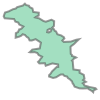

In [95]:
from shapely.geometry import shape

#dam_nominal = shape(input_json["geometry"])
dam_nominal = nominal_outline
# print(dam_nominal)
# inflate the BBOX 
inflate_bbox = 0 #0.1
minx, miny, maxx, maxy = dam_nominal.bounds

delx = maxx - minx
dely = maxy - miny
minx = minx - delx * inflate_bbox
maxx = maxx + delx * inflate_bbox
miny = miny - dely * inflate_bbox
maxy = maxy + dely * inflate_bbox
    
dam_bbox = BBox([minx, miny, maxx, maxy], crs=CRS.WGS84)
dam_nominal

# for geom in dam_nominal.geoms:
#     plt.plot(*geom.exterior.xy)


In [96]:
download_task = SentinelHubInputTask(data_collection=DataCollection.SENTINEL2_L1C, 
                                     bands_feature=(FeatureType.DATA, 'BANDS'),
                                     resolution=20, 
                                     maxcc=0.5, 
                                     bands=['B02', 'B03', 'B04', 'B08'], 
                                     additional_data=[(FeatureType.MASK, 'dataMask', 'IS_DATA'), (FeatureType.MASK, 'CLM')],
                                     config=config
                                    )

calculate_ndwi = NormalizedDifferenceIndexTask((FeatureType.DATA, 'BANDS'), (FeatureType.DATA, 'NDWI'), (1, 3))

In [97]:
dam_gdf = gpd.GeoDataFrame(crs=CRS.WGS84.pyproj_crs(), geometry=[dam_nominal])


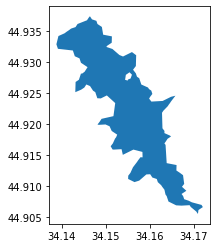

In [98]:
dam_gdf.plot();

In [99]:
add_nominal_water = VectorToRaster(dam_gdf, (FeatureType.MASK_TIMELESS, 'NOMINAL_WATER'), values=1, 
                                   raster_shape=(FeatureType.MASK, 'IS_DATA'), raster_dtype=np.uint8)

/home/vlas/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [100]:


def calculate_valid_data_mask(eopatch):
    is_data_mask = eopatch.mask['IS_DATA'].astype(np.bool)
    cloud_mask = ~eopatch.mask['CLM'].astype(np.bool)
    return np.logical_and(is_data_mask, cloud_mask)

add_valid_mask = AddValidDataMaskTask(predicate=calculate_valid_data_mask)

/home/vlas/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [101]:
def calculate_coverage(array):
    return 1.0 - np.count_nonzero(array) / np.size(array)

class AddValidDataCoverage(EOTask):
    
    def execute(self, eopatch):
        
        valid_data = eopatch.get_feature(FeatureType.MASK, 'VALID_DATA')
        time, height, width, channels = valid_data.shape
        
        coverage = np.apply_along_axis(calculate_coverage, 1,
                                       valid_data.reshape((time, height * width * channels)))
        
        eopatch.add_feature(FeatureType.SCALAR, 'COVERAGE', coverage[:, np.newaxis])
        return eopatch
    
add_coverage = AddValidDataCoverage()

In [102]:
cloud_coverage_threshold = 0.05 

class ValidDataCoveragePredicate:
    
    def __init__(self, threshold):
        self.threshold = threshold
        
    def __call__(self, array):
        return calculate_coverage(array) < self.threshold
    
remove_cloudy_scenes = SimpleFilterTask((FeatureType.MASK, 'VALID_DATA'),
                                        ValidDataCoveragePredicate(cloud_coverage_threshold))

In [103]:
class WaterDetector(EOTask):
    
    @staticmethod
    def detect_water(ndwi):
        """
        Very simple water detector based on Otsu thresholding method of NDWI.
        """
        otsu_thr = 1.0
        if len(np.unique(ndwi)) > 1:
            ndwi[np.isnan(ndwi)] = -1
            otsu_thr = threshold_otsu(ndwi)

        return ndwi > otsu_thr

    def execute(self, eopatch):
        water_masks = np.asarray([self.detect_water(ndwi[...,0]) for ndwi in eopatch.data['NDWI']])
        
        # we're only interested in the water within the dam borders
        water_masks = water_masks[...,np.newaxis] * eopatch.mask_timeless['NOMINAL_WATER']
        
        water_levels = np.asarray([np.count_nonzero(mask)/np.count_nonzero(eopatch.mask_timeless['NOMINAL_WATER']) 
                                   for mask in water_masks])
        
        eopatch.add_feature(FeatureType.MASK, 'WATER_MASK', water_masks)
        eopatch.add_feature(FeatureType.SCALAR, 'WATER_LEVEL', water_levels[...,np.newaxis])
        
        return eopatch
    
water_detection = WaterDetector()

In [104]:
workflow = LinearWorkflow(download_task, calculate_ndwi, add_nominal_water, add_valid_mask,
                          add_coverage, remove_cloudy_scenes, water_detection)

In [105]:
#time_interval = [input_json['features'][0]["startDate"],input_json['features'][0]["endDate"]]
time_interval = '2021-01-06', '2021-04-26'

In [106]:
result = workflow.execute({
    download_task: {
        'bbox': dam_bbox,
        'time_interval': time_interval
    },
})

/home/vlas/.local/lib/python3.8/site-packages/eolearn/features/bands_extraction.py:86: RuntimeWarning: invalid value encountered in true_divide
  ndi = (band_a - band_b + self.acorvi_constant) / (band_a + band_b + self.acorvi_constant)
<ipython-input-100-1d363147cad0>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  is_data_mask = eopatch.mask['IS_DATA'].astype(np.bool)
<ipython-input-100-1d363147cad0>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy

In [107]:
eopatch = list(result.values())[-1]

In [124]:
from skimage.filters import sobel
from skimage.morphology import disk
from skimage.morphology import erosion, dilation, opening, closing, white_tophat, binary_dilation

In [109]:
eopatch

EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(8, 179, 129, 4), dtype=float32)
    NDWI: numpy.ndarray(shape=(8, 179, 129, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(8, 179, 129, 1), dtype=uint8)
    IS_DATA: numpy.ndarray(shape=(8, 179, 129, 1), dtype=bool)
    VALID_DATA: numpy.ndarray(shape=(8, 179, 129, 1), dtype=bool)
    WATER_MASK: numpy.ndarray(shape=(8, 179, 129, 1), dtype=uint8)
  }
  scalar: {
    COVERAGE: numpy.ndarray(shape=(8, 1), dtype=float64)
    WATER_LEVEL: numpy.ndarray(shape=(8, 1), dtype=float64)
  }
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    NOMINAL_WATER: numpy.ndarray(shape=(179, 129, 1), dtype=uint8)
  }
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    maxcc: 0.5
    size_x: 129
    size_y: 179
    time_difference: datetime.timedelta(seconds=1)
    time_interval: (datetime.datetime(2021, 1, 6, 0, 0), datetime.datetime(2021, 4, 26, 23, 59, 59))
  }
  bbox: BBox(((34.13877368164

In [111]:
from matplotlib import patches, patheffects
from shapely.geometry import MultiPolygon, Polygon

In [113]:
import rasterio
from rasterio import features
import shapely
from shapely.geometry import Point, Polygon

def mask_to_polygons_layer(mask, eopatch, tolerance):
    
    all_polygons = []
    bbox = eopatch.bbox
    size_x = eopatch.meta_info['size_x']
    size_y = eopatch.meta_info['size_y']
    
    vx = bbox.min_x
    vy = bbox.max_y
    cx = (bbox.max_x-bbox.min_x)/size_x
    cy = (bbox.max_y-bbox.min_y)/size_y
    
    for shape, value in features.shapes(mask.astype(np.int16), mask=(mask == 1), transform=rasterio.Affine(cx, 0.0, vx,
       0.0, -cy, vy)): 
        return shapely.geometry.shape(shape).simplify(tolerance, False)
        all_polygons.append(shapely.geometry.shape(shape))
    
    all_polygons = shapely.geometry.MultiPolygon(all_polygons)
    if not all_polygons.is_valid:
        all_polygons = all_polygons.buffer(0)
        # Sometimes buffer() converts a simple Multipolygon to just a Polygon,
        # need to keep it a Multi throughout
        if all_polygons.type == 'Polygon':
            all_polygons = shapely.geometry.MultiPolygon([all_polygons])
    return all_polygons


def toGeoJson (shape):
    return json.dumps(shapely.geometry.mapping(shape))


In [114]:

def plot_rgb_w_water(eopatch, idx):
    ratio = np.abs(eopatch.bbox.max_x - eopatch.bbox.min_x) / np.abs(eopatch.bbox.max_y - eopatch.bbox.min_y)
    
    tolerance = 0.00025
    
    observed = eopatch.mask['WATER_MASK'][idx,...,0]
    observed = dilation(observed)
    observed = np.ma.masked_where(observed == False, observed)
    observedShape = mask_to_polygons_layer(observed, eopatch, tolerance)# вернуть
    return toGeoJson(observedShape)

In [115]:
# geometry
fetch_data = plot_rgb_w_water(eopatch, 0)

In [118]:
def plot_water_levels(eopatch, max_coverage=1.0):
    fig, ax = plt.subplots(figsize=(20,7))

    dates = np.asarray(eopatch.timestamp)
    ax.plot(dates[eopatch.scalar['COVERAGE'][...,0]<max_coverage],
            eopatch.scalar['WATER_LEVEL'][eopatch.scalar['COVERAGE'][...,0]<max_coverage],
            'bo-',alpha=0.7, label='Water Level')
    ax.plot(dates[eopatch.scalar['COVERAGE'][...,0]<max_coverage],
            eopatch.scalar['COVERAGE'][eopatch.scalar['COVERAGE'][...,0]<max_coverage],
            '--',color='gray',alpha=0.7, label='Cloud Coverage')
    ax.set_ylim(0.0,1.1)
    ax.set_xlabel('Date')
    ax.set_ylabel('Water Level')
    ax.set_title('Detected Water Level')
    ax.grid(axis='y')
    ax.legend(loc='best')
    return ax

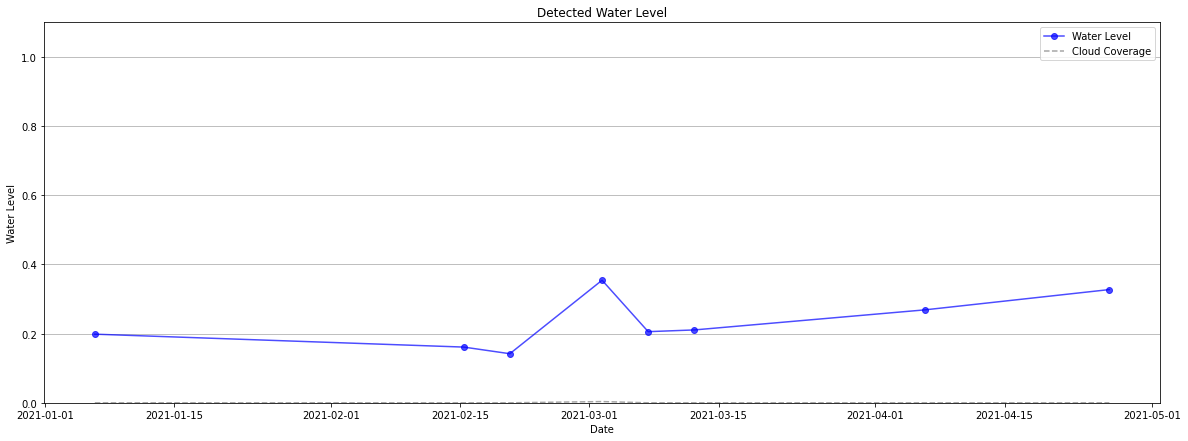

In [119]:
ax = plot_water_levels(eopatch, 1.0);

In [82]:
eopatch #COVERAGE  WATER_LEVEL  bbox+CRS  timestamp

EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(5, 109, 94, 4), dtype=float32)
    NDWI: numpy.ndarray(shape=(5, 109, 94, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(5, 109, 94, 1), dtype=uint8)
    IS_DATA: numpy.ndarray(shape=(5, 109, 94, 1), dtype=bool)
    VALID_DATA: numpy.ndarray(shape=(5, 109, 94, 1), dtype=bool)
    WATER_MASK: numpy.ndarray(shape=(5, 109, 94, 1), dtype=uint8)
  }
  scalar: {
    COVERAGE: numpy.ndarray(shape=(5, 1), dtype=float64)
    WATER_LEVEL: numpy.ndarray(shape=(5, 1), dtype=float64)
  }
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    NOMINAL_WATER: numpy.ndarray(shape=(109, 94, 1), dtype=uint8)
  }
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    maxcc: 0.5
    size_x: 94
    size_y: 109
    time_difference: datetime.timedelta(seconds=1)
    time_interval: (datetime.datetime(2020, 3, 5, 0, 0), datetime.datetime(2020, 4, 5, 23, 59, 59))
  }
  bbox: BBox(((35.3071403503418, 45.13

In [120]:
def get_observed_shape(eopatch, idx):
    ratio = np.abs(eopatch.bbox.max_x - eopatch.bbox.min_x) / np.abs(eopatch.bbox.max_y - eopatch.bbox.min_y)
    
    tolerance = 0.00025
    
    observed = eopatch.mask['WATER_MASK'][idx,...,0]
    observed = dilation(observed)
    observed = np.ma.masked_where(observed == False, observed)
    observedShape = mask_to_polygons_layer(observed, eopatch, tolerance)
    return toGeoJson(observedShape)

In [125]:
def get_water_mask_from_S2(ndwi, canny_sigma=4, canny_threshold=0.3, selem=disk(4)):
    """
    Make water detection on input NDWI single band image.
    
    """
    # default threshold (no water detected)
    otsu_thr = 1.0
    status = 0
    
    # transform NDWI values to [0,1]
    ndwi_std = (ndwi - np.min(ndwi))/np.ptp(ndwi)
    
    if len(np.unique(ndwi)) > 1:
        edges = canny(ndwi_std, sigma=canny_sigma, high_threshold=canny_threshold)
        edges = binary_dilation(edges, selem)
        ndwi_masked = ma.masked_array(ndwi, mask=np.logical_not(edges))
        
        if len(np.unique(ndwi_masked.data[~ndwi_masked.mask])) > 1:
            # threshold determined using dilated canny edge + otsu
            otsu_thr = threshold_otsu(ndwi_masked.data[~ndwi_masked.mask])
            status = 1

            # if majority of pixels above threshold have negative NDWI values
            # change the threshold to 0.0
            fraction = np.count_nonzero(ndwi>0)/np.count_nonzero(ndwi>otsu_thr)
            if fraction < 0.9:
                otsu_thr = 0.0
                status = 3
        else:
            # theshold determined with otsu on entire image
            otsu_thr = threshold_otsu(ndwi)
            status = 2
            
            # if majority of pixels above threshold have negative NDWI values
            # change the threshold to 0.0
            fraction = np.count_nonzero(ndwi>0)/np.count_nonzero(ndwi>otsu_thr)
            if fraction < 0.9:
                otsu_thr = 0.0
                status = 4

    return status, (ndwi>otsu_thr).astype(np.uint8)

def get_water_level_optical(timestamp, ndwi, dam_poly, dam_bbox, simplify=True):
    """
    Run water detection algorithm for an NDWI image.
    """
    water_det_status, water_mask = get_water_mask_from_S2(ndwi)
    measured_water_extent = get_water_extent(water_mask, dam_poly, dam_bbox, simplify)
    
    return {'alg_status':water_det_status,
            'water_level':measured_water_extent.area/dam_poly.area,
            'geometry':measured_water_extent}

class WaterDetector(EOTask):
    def execute(self, eopatch):
        
        results = [get_water_level_optical(date, eopatch.data['NDWI'][idx,...,0], geom, bbox, simplify=True) for idx, date in enumerate(eopatch.timestamp)]
        
        df = list([x['geometry'] for x in results])
        gdf = gpd.GeoDataFrame(geometry = df, crs = {'init': eopatch.bbox.crs.ogc_string()})
        gdf['TIMESTAMP'] = eopatch.timestamp
        
        eopatch.add_feature(FeatureType.VECTOR, 'WATER_OUTLINE', gdf)
        eopatch.add_feature(FeatureType.SCALAR, 'WATER_LEVEL', np.array([x['water_level'] for x in results])[..., np.newaxis])
        
        return eopatch

In [ ]:
water_det = WaterDetector()

In [121]:

from skimage.morphology import dilation
get_observed_shape(eopatch, 0)


'{"type": "Polygon", "coordinates": [[[34.1449776923602, 44.93558977896407], [34.14575319370013, 44.935411732934696], [34.14549469325349, 44.934877594846576], [34.14627019459342, 44.934877594846576], [34.14704569593336, 44.934343456758455], [34.14756269682665, 44.933097134552845], [34.148338198166584, 44.93345322661159], [34.14937219995316, 44.93291908852347], [34.14911369950652, 44.93220690440598], [34.15092320263304, 44.93113862822974], [34.15144020352633, 44.930248398082874], [34.153508207099485, 44.92971425999475], [34.152991206206195, 44.92935816793601], [34.152991206206195, 44.92828989175977], [34.154025207992774, 44.92757770764228], [34.154025207992774, 44.92686552352478], [34.15454220888607, 44.92668747749541], [34.155317710226, 44.925441155289796], [34.15609321156594, 44.92508506323105], [34.15635171201258, 44.92330460293732], [34.15609321156594, 44.922414372790456], [34.154025207992774, 44.92170218867296], [34.152991206206195, 44.92223632676108], [34.152474205312906, 44.92330

In [122]:
import geojson
output = []

for i in range(len(eopatch.scalar['WATER_LEVEL'])):
    numpyData = {"measurement_date": eopatch.timestamp[i].strftime('%d/%m/%Y'), "bbox": eopatch.bbox.geometry.bounds, "crs": eopatch.bbox.crs.epsg, "water_level": eopatch.scalar['WATER_LEVEL'][i,0], "cloud_coverage": eopatch.scalar['COVERAGE'][i,0], "measurement_type": "observed"}
    #obJect = {"type": "Feature", "properties": numpyData, "geometry": get_observed_shape(eopatch, i)}
    obJect = {"type": "FeatureCollection", "features":[{"type":"Feature", "properties": numpyData, "geometry": get_observed_shape(eopatch, i)}]}
    output.append(obJect)

#output_json = json.dumps(output, ensure_ascii=False).encode('utf-8')
#json.loads(json.dumps(output_json))
#json.dump(output, open("result2.json","w"), ensure_ascii=False)
# with open('data.json', 'a') as f:
#     json.dump(output, f)

In [123]:
output

[{'type': 'FeatureCollection',
  'features': [{'type': 'Feature',
    'properties': {'measurement_date': '06/01/2021',
     'bbox': (34.138773681640714,
      44.9055,
      34.172120239257936,
      44.9373702392578),
     'crs': 4326,
     'water_level': 0.19839830764581445,
     'cloud_coverage': 0.0,
     'measurement_type': 'observed'},
    'geometry': '{"type": "Polygon", "coordinates": [[[34.1449776923602, 44.93558977896407], [34.14575319370013, 44.935411732934696], [34.14549469325349, 44.934877594846576], [34.14627019459342, 44.934877594846576], [34.14704569593336, 44.934343456758455], [34.14756269682665, 44.933097134552845], [34.148338198166584, 44.93345322661159], [34.14937219995316, 44.93291908852347], [34.14911369950652, 44.93220690440598], [34.15092320263304, 44.93113862822974], [34.15144020352633, 44.930248398082874], [34.153508207099485, 44.92971425999475], [34.152991206206195, 44.92935816793601], [34.152991206206195, 44.92828989175977], [34.154025207992774, 44.927577707